In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src.room_and_object_types import CATEGORIES_TO_TYPES, EMPTY_OBJECT
from src.fitness_features import COMMON_SENSE_PREDICATES_FUNCTIONS, PREDICATE_FUNCTION_ARITY_MAP
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [5]:
BINARIZE_IGNORE_FEATURES = [
    'setup_objects_used', 'starts_and_ends_once', 'correct_predicate_function_arity',
    'section_without_pref_count_terminal', 'section_without_pref_count_scoring'
]  

BINARIZE_IGNORE_PATTERNS = [
    re.compile(r'max_depth_[\w\d_]+'), 
    re.compile(r'mean_depth_[\w\d_]+'), 
    re.compile(r'node_count_[\w\d_]+')
]  

BINARIZE_NON_ONE = [
    'all_variables_defined', 'all_variables_used', 
    'all_preferences_used', 'no_adjacent_once', 'variable_not_repeated',
    'no_nested_logicals', 'no_identical_logical_children',     
    'count_once_per_external_objects_used_correctly',         
    'external_forall_used_correctly', 'pref_forall_used',        
    'pref_forall_correct_arity', 'pref_forall_correct_types', 'no_two_number_operations'
]  

BINRARIZE_NONZERO_PATTERNS = [
    re.compile(r'arg_types_[\w_]+'), 
    re.compile(r'compositionality_structure_\d+')
]   

def binarize_features(df: pd.DataFrame, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS) -> pd.DataFrame:
    binarized_df = df.copy(deep=True)

    for c in binarized_df.columns:
        if c in ignore_columns:
            continue

        if c in BINARIZE_IGNORE_FEATURES:
            continue 
        
        if any([p.match(c) for p in BINARIZE_IGNORE_PATTERNS]):
            continue

        if c in BINARIZE_NON_ONE:
            binarized_df[c] = (binarized_df[c] == 1).astype(int)

        if any([p.match(c) for p in BINRARIZE_NONZERO_PATTERNS]):
            binarized_df[c] = (binarized_df[c] != 0).astype(int)

    return binarized_df


binarized_df = binarize_features(fitness_df)

In [6]:
binarized_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,1,0,0,0,0,0,0,1,0,0


In [7]:
def _merge_single_prefix(df: pd.DataFrame, feature_prefix: str, threshold: int = 10, 
    merge_function: typing.Callable = np.logical_or, merged_column_suffix: str = 'other') -> None:
    
    insert_index = list(df.columns).index(f'{feature_prefix}_ramps')
    counts = df[[c for c in df.columns if c.startswith(feature_prefix)]].sum()
    keys_to_merge = counts.index[counts < threshold]  # type: ignore
    if len(keys_to_merge) == 0:
        print(feature_prefix)
        return
    new_series_values = reduce(merge_function, [df[k] for k in keys_to_merge[1:]], df[keys_to_merge[0]]).sum()
    
    merged_column_key = f'{feature_prefix}_{merged_column_suffix}'
    df.insert(insert_index, merged_column_key, new_series_values)
    df.drop(keys_to_merge, axis=1, inplace=True)
    

def merge_sparse_features(df: pd.DataFrame, threshold: int = 10, 
    merge_function: typing.Callable = np.logical_or, merged_column_suffix: str = 'other') -> pd.DataFrame:
    df = df.copy(deep=True)

    for p in COMMON_SENSE_PREDICATES_FUNCTIONS:
        if p not in PREDICATE_FUNCTION_ARITY_MAP:
            raise ValueError(f'Predicate {p} not in arity map')
        
        arity = PREDICATE_FUNCTION_ARITY_MAP[p]
        if arity == 1:
            feature_prefix = f'arg_types_{p}'
            _merge_single_prefix(df, feature_prefix, threshold, merge_function, merged_column_suffix)

        else:  # arity = 2
            for c in CATEGORIES_TO_TYPES.keys():
                if c == EMPTY_OBJECT:
                    continue
                feature_prefix = f'arg_types_{p}_{c}'
                _merge_single_prefix(df, feature_prefix, threshold, merge_function, merged_column_suffix)

    return df
                


In [11]:
merged_binarized_df = merge_sparse_features(binarized_df, threshold=10)
merged_binarized_df.head()

arg_types_agent_holds
arg_types_in_motion


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,1,0,0,0,0,0,0,1,0,0


In [12]:
merged_binarized_df.columns[20:40]

Index(['correct_predicate_function_arity', 'no_two_number_operations',
       'section_without_pref_or_total_count_terminal',
       'section_without_pref_or_total_count_scoring',
       'arg_types_adjacent_agent_balls', 'arg_types_adjacent_agent_blocks',
       'arg_types_adjacent_agent_furniture',
       'arg_types_adjacent_agent_large_objects',
       'arg_types_adjacent_agent_other', 'arg_types_adjacent_agent_ramps',
       'arg_types_adjacent_agent_receptacles',
       'arg_types_adjacent_agent_room_features',
       'arg_types_adjacent_any_object_any_object',
       'arg_types_adjacent_any_object_other', 'arg_types_adjacent_balls_agent',
       'arg_types_adjacent_balls_balls', 'arg_types_adjacent_balls_furniture',
       'arg_types_adjacent_balls_other',
       'arg_types_adjacent_balls_receptacles',
       'arg_types_adjacent_balls_room_features'],
      dtype='object')

**TODO**: theoretically we'd want to first train-test split and then merge features, but for a quick POC I'm doing it in the opposite order

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


### Test results:

{'ecdf': -0.6833076923076924, 'game_rank': 0.13124999403953552}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1010,16,4,<function fitness_square_square_loss at 0x1608...,0.003,1,392,1.00,-0.339506,0.019061,1,0.722604,0.043223,12
1268,16,64,<function fitness_square_square_loss at 0x1608...,0.003,2,392,0.00,-0.339526,0.018834,2,0.721497,0.041626,26
1270,16,64,<function fitness_square_square_loss at 0x1608...,0.003,2,392,1.00,-0.339552,0.018662,3,0.723164,0.042950,8
1204,16,32,<function fitness_square_square_loss at 0x1608...,0.003,2,392,0.00,-0.339591,0.018967,4,0.722734,0.046542,11
1211,16,32,<function fitness_square_square_loss at 0x1608...,0.003,4,392,2.00,-0.339601,0.018627,5,0.722865,0.040491,10
1205,16,32,<function fitness_square_square_loss at 0x1608...,0.003,2,392,0.25,-0.339626,0.018795,6,0.724258,0.045027,3
1136,16,16,<function fitness_square_square_loss at 0x1608...,0.003,1,392,0.00,-0.339631,0.018980,7,0.723060,0.041419,9
1273,16,64,<function fitness_square_square_loss at 0x1608...,0.003,4,392,0.25,-0.339631,0.018854,8,0.721185,0.043569,29
1272,16,64,<function fitness_square_square_loss at 0x1608...,0.003,4,392,0.00,-0.339667,0.018866,9,0.723932,0.041253,5
1022,16,4,<function fitness_square_square_loss at 0x1608...,0.003,8,392,1.00,-0.339671,0.019100,10,0.720612,0.043856,37


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1011,16,4,<function fitness_square_square_loss at 0x1608...,0.003,1,392,2.00,-0.339706,0.018529,12,0.724818,0.038730,1
1077,16,8,<function fitness_square_square_loss at 0x1608...,0.003,2,392,0.25,-0.339905,0.018426,37,0.724596,0.048197,2
1205,16,32,<function fitness_square_square_loss at 0x1608...,0.003,2,392,0.25,-0.339626,0.018795,6,0.724258,0.045027,3
1271,16,64,<function fitness_square_square_loss at 0x1608...,0.003,2,392,2.00,-0.339750,0.018581,14,0.724063,0.043055,4
1272,16,64,<function fitness_square_square_loss at 0x1608...,0.003,4,392,0.00,-0.339667,0.018866,9,0.723932,0.041253,5
1206,16,32,<function fitness_square_square_loss at 0x1608...,0.003,2,392,1.00,-0.339840,0.018544,27,0.723789,0.043085,6
1145,16,16,<function fitness_square_square_loss at 0x1608...,0.003,4,392,0.25,-0.339728,0.018422,13,0.723190,0.037490,7
1270,16,64,<function fitness_square_square_loss at 0x1608...,0.003,2,392,1.00,-0.339552,0.018662,3,0.723164,0.042950,8
1136,16,16,<function fitness_square_square_loss at 0x1608...,0.003,1,392,0.00,-0.339631,0.018980,7,0.723060,0.041419,9
1211,16,32,<function fitness_square_square_loss at 0x1608...,0.003,4,392,2.00,-0.339601,0.018627,5,0.722865,0.040491,10


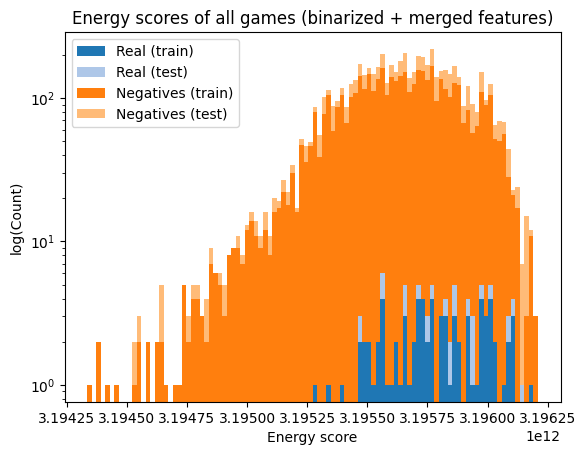

403447700.0 951147400.0 130941770.0


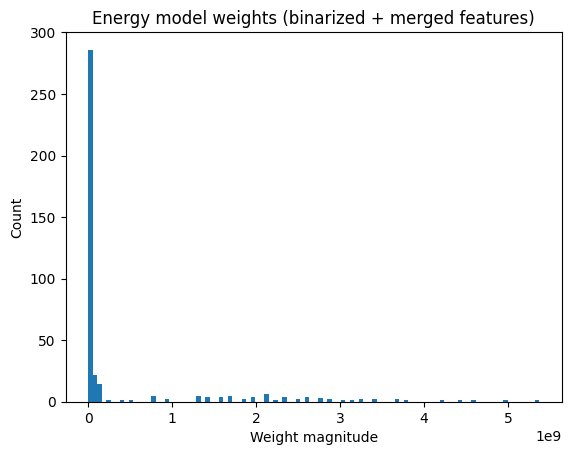

In [16]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_merged_binarized_features_sq_sq, (train_tensor_merged_binarized_features_sq_sq, test_tensor_merged_binarized_features_sq_sq), test_results_merged_binarized_features_sq_sq = utils.model_fitting_experiment(
    merged_binarized_df, test_param_grid, random_seed=42,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_merged_binarized_features_sq_sq, train_tensor_merged_binarized_features_sq_sq, test_tensor_merged_binarized_features_sq_sq, test_results_merged_binarized_features_sq_sq, histogram_title_note='binarized + merged features')

### Test results:

{'ecdf': -0.6715384615384615, 'game_rank': 0.12187500298023224}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1102,16,16,<function fitness_square_square_loss at 0x1608...,0.100,8,392,1.00,-0.325837,0.027969,1,0.731042,0.023667,30
1101,16,16,<function fitness_square_square_loss at 0x1608...,0.100,8,392,0.25,-0.325849,0.027991,2,0.730065,0.024483,56
1231,16,64,<function fitness_square_square_loss at 0x1608...,0.100,8,392,2.00,-0.325874,0.028126,3,0.729870,0.024537,64
1022,16,4,<function fitness_square_square_loss at 0x1608...,0.003,8,392,1.00,-0.325875,0.028351,4,0.735417,0.021906,7
1039,16,8,<function fitness_square_square_loss at 0x1608...,0.100,8,392,2.00,-0.325906,0.027883,5,0.729674,0.024714,67
1103,16,16,<function fitness_square_square_loss at 0x1608...,0.100,8,392,2.00,-0.325920,0.027973,6,0.730260,0.024278,51
1215,16,32,<function fitness_square_square_loss at 0x1608...,0.003,8,392,2.00,-0.325939,0.028168,7,0.737839,0.022587,2
1037,16,8,<function fitness_square_square_loss at 0x1608...,0.100,8,392,0.25,-0.325942,0.028143,8,0.729466,0.024377,77
1084,16,8,<function fitness_square_square_loss at 0x1608...,0.003,8,392,0.00,-0.325949,0.028363,9,0.738138,0.020833,1
1100,16,16,<function fitness_square_square_loss at 0x1608...,0.100,8,392,0.00,-0.325971,0.027989,10,0.729661,0.024200,70


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1084,16,8,<function fitness_square_square_loss at 0x1608...,0.003,8,392,0.00,-0.325949,0.028363,9,0.738138,0.020833,1
1215,16,32,<function fitness_square_square_loss at 0x1608...,0.003,8,392,2.00,-0.325939,0.028168,7,0.737839,0.022587,2
1277,16,64,<function fitness_square_square_loss at 0x1608...,0.003,8,392,0.25,-0.326344,0.027781,71,0.736445,0.024198,3
1149,16,16,<function fitness_square_square_loss at 0x1608...,0.003,8,392,0.25,-0.326107,0.028086,27,0.736198,0.022426,4
1278,16,64,<function fitness_square_square_loss at 0x1608...,0.003,8,392,1.00,-0.326247,0.027922,56,0.735664,0.024163,5
1148,16,16,<function fitness_square_square_loss at 0x1608...,0.003,8,392,0.00,-0.326107,0.028107,27,0.735625,0.023423,6
1022,16,4,<function fitness_square_square_loss at 0x1608...,0.003,8,392,1.00,-0.325875,0.028351,4,0.735417,0.021906,7
1214,16,32,<function fitness_square_square_loss at 0x1608...,0.003,8,392,1.00,-0.326148,0.028119,36,0.735078,0.024382,8
1151,16,16,<function fitness_square_square_loss at 0x1608...,0.003,8,392,2.00,-0.326100,0.028060,24,0.735026,0.023038,9
1150,16,16,<function fitness_square_square_loss at 0x1608...,0.003,8,392,1.00,-0.326148,0.027946,35,0.734596,0.022986,10


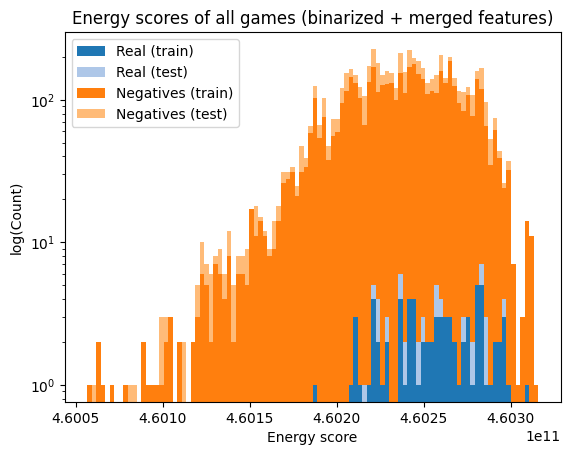

58109304.0 136982430.0 18858216.0


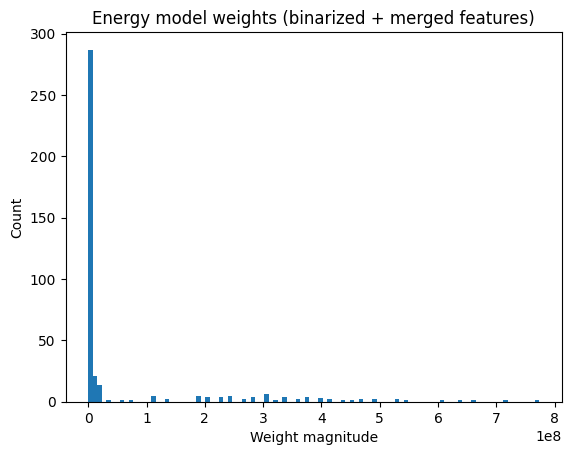

In [14]:
utils.visualize_cv_outputs(cv_merged_binarized_features_sq_sq, train_tensor_merged_binarized_features_sq_sq, test_tensor_merged_binarized_features_sq_sq, test_results_merged_binarized_features_sq_sq, histogram_title_note='binarized + merged features')

In [15]:
cv_merged_binarized_features_sq_sq.best_estimator_.transform(train_tensor_merged_binarized_features_sq_sq)

tensor([[[4.6026e+11],
         [4.6009e+11],
         [4.6026e+11],
         ...,
         [4.6024e+11],
         [4.6026e+11],
         [4.6025e+11]],

        [[4.6025e+11],
         [4.6022e+11],
         [4.6019e+11],
         ...,
         [4.6012e+11],
         [4.6025e+11],
         [4.6022e+11]],

        [[4.6029e+11],
         [4.6029e+11],
         [4.6027e+11],
         ...,
         [4.6029e+11],
         [4.6029e+11],
         [4.6025e+11]],

        ...,

        [[4.6024e+11],
         [4.6024e+11],
         [4.6024e+11],
         ...,
         [4.6024e+11],
         [4.6023e+11],
         [4.6024e+11]],

        [[4.6026e+11],
         [4.6026e+11],
         [4.6026e+11],
         ...,
         [4.6021e+11],
         [4.6024e+11],
         [4.6022e+11]],

        [[4.6025e+11],
         [4.6025e+11],
         [4.6024e+11],
         ...,
         [4.6024e+11],
         [4.6026e+11],
         [4.6026e+11]]], grad_fn=<AddBackward0>)

In [17]:
train_tensor_merged_binarized_features_sq_sq[0]

tensor([[1., 1., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.]])